### xgboost model to predict mean player outcomes
used in conjunction with nn algs to determine mean wrc for player. Three diffrent models based on available data then combinded to create an xgb predection.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [2]:
# import data
data_23_24 = pd.read_csv('./data/cleaned/data_23_24.csv')
df = data_23_24.drop(columns=['Unnamed: 0'])
df = df.dropna()

#### find the z_score of each stat
weighted avg of year, std of year, 10 away from 100 is one std


In [3]:
def mean_year(group):
        avg = np.average(group, weights=group.index.map(lambda x: df.loc[x, 'PA']))
        return avg

In [4]:
# weighted std to account for low PA outlier preformances
def calculate_weighted_std(group):
    avg = np.average(group, weights=group.index.map(lambda x: df.loc[x, 'PA']))
    variance = np.average((group - avg)**2, weights=group.index.map(lambda x: df.loc[x, 'PA']))
    return np.sqrt(variance)

In [5]:
def z_scores(player_df, mean_df, std_df):
    # z scores for each stat and player, also creating a new df flow, add back names based on MLBAMID later
    z_scores = pd.DataFrame(index=player_df.index, columns=player_df.select_dtypes(include=[np.number]).columns)

    # scaled for each col
    for col in player_df.select_dtypes(include=[np.number]).columns:
        if col not in ['Season', 'MLBAMID']:  # not needed
            for idx in player_df.index:
                season = player_df.loc[idx, 'Season']
                value = player_df.loc[idx, col]
                mean = mean_df.loc[mean_df['Season'] == season, col].iloc[0]
                std = std_df.loc[std_df['Season'] == season, col].iloc[0]
                # scale so that 10 is 1 std away
                z_scores.loc[idx, col] = 100 + ((value - mean) / std * 10)

    z_scores['Season'] = player_df['Season']
    
    # cols to numeric
    for col in z_scores.columns:
        if col not in ['Season', 'MLBAMID']:
            z_scores[col] = pd.to_numeric(z_scores[col])
    
    # reinsert player names
    z_scores.insert(0, 'Name', player_df['Name']) 

    return z_scores

In [6]:
# df to store mean results
mean_values = pd.DataFrame(index=df['Season'].unique())

for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_mean = df.groupby('Season')[col].apply(mean_year)
        mean_values[col] = yearly_mean

# reset and rename index
mean_values = mean_values.reset_index()
mean_values = mean_values.rename(columns={'index': 'Season'})

# sort and display
mean_values = mean_values.sort_values(by=['Season'])
mean_values.head()

,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,...,bb_percent,woba,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
0,2023,446.221213,27.977189,0.085983,0.227243,0.296656,100.236902,0.052217,3.800717,-1.336130,...,8.601494,0.318553,0.320352,33.959502,8.335061,39.656425,99.865646,94.204951,25.523627,47.722911
1,2024,447.381885,27.939266,0.081851,0.226063,0.291184,100.084642,0.027876,3.517452,-1.126462,...,8.184799,0.310247,0.312341,33.907515,8.037711,39.175173,99.695445,94.114469,25.132269,48.125014


In [7]:
# Create empty DataFrame to store results
std_values = pd.DataFrame(index=df['Season'].unique())

# Loop through numeric columns
for col in df.select_dtypes(include=[np.number]).columns:
    if col != 'Season' and col != 'MLBAMID':  # skip meaningless numeric
        yearly_std = df.groupby('Season')[col].apply(calculate_weighted_std)
        std_values[col] = yearly_std

std_values = std_values.reset_index()
std_values = std_values.rename(columns={'index': 'Season'})

std_values = std_values.sort_values(by=['Season'])
std_values.head()

,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,Def,...,bb_percent,woba,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
0,2023,184.640874,3.676013,0.031614,0.063200,0.041398,28.804999,2.741822,15.148537,8.204844,...,3.160195,0.041785,0.039241,4.295183,4.296957,8.054790,2.490148,1.443158,6.280495,5.035636
1,2024,181.345314,3.623815,0.028821,0.062645,0.038889,29.403954,2.684778,15.563986,8.416453,...,2.883528,0.042365,0.039278,4.165549,4.189756,8.161489,2.604874,1.512985,6.330819,4.873296


apply z scores

In [8]:
z_score_df = z_scores(player_df=df, mean_df=mean_values, std_df=std_values)
z_score_df.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,bb_percent,woba,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent
0,aaron hicks,2023,92.730688,113.663746,115.383212,99.036504,103.436200,103.009224,103.689726,100.390931,...,115.500641,101.782182,90.226519,82.400047,89.911325,87.266675,87.129859,87.198924,100.121603,85.259238
1,aaron hicks,2024,78.803870,116.724734,104.644954,122.191113,79.669692,72.758068,100.503868,94.138796,...,104.561084,73.033048,83.619107,96.380995,94.897767,95.251880,99.781672,100.079318,112.111753,91.535474
2,aaron judge,2023,100.637930,108.223069,133.579146,108.955677,100.926857,124.953327,91.050337,122.030436,...,133.537500,124.278450,135.841921,107.311674,144.601185,130.470781,130.291418,138.414595,117.636146,87.245085
3,aaron judge,2024,114.150799,111.205688,137.149845,102.687322,119.616021,140.246539,98.231326,158.744597,...,137.160040,139.124692,142.430135,116.546403,145.020012,126.741231,128.811338,132.976083,108.794646,87.431476
4,aaron schunk,2024,80.733890,94.648551,85.762277,114.408724,109.433020,82.786786,97.486170,93.519697,...,85.834024,87.431585,80.563989,113.905694,92.272316,90.840920,85.310293,85.769960,103.897965,121.289464


### xgboost model

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

make wrc+ value the next year

In [10]:
# remove 2024 to train model bc we do not know the following year
train_z = z_score_df[z_score_df['Season'] < 2024].copy()
train_z['next_wrc+'] = np.nan # empty col


for idx in train_z.index:
    # retrive name, season
    name = train_z.loc[idx, 'Name']
    season = train_z.loc[idx, 'Season']
    # full df
    next_year_noscale = df[(df['Name'] == name) & (df['Season'] == season + 1)]
    next_year_scaled = z_score_df[(z_score_df['Name'] == name) & (z_score_df['Season'] == season + 1)]

    # add to df
    if not next_year_noscale.empty:
        train_z.loc[idx, 'next_wrc+'] = next_year_noscale['wRC+'].iloc[0]
        train_z.loc[idx, 'next_pa'] = next_year_scaled['PA'].iloc[0] # need for later anaylsis

# remove rows of nas | players retired etc.
train_z = train_z.dropna(subset=['next_wrc+'])

# display
train_z.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,next_wrc+,next_pa
0,aaron hicks,2023,92.730688,113.663746,115.383212,99.036504,103.436200,103.009224,103.689726,100.390931,...,90.226519,82.400047,89.911325,87.266675,87.129859,87.198924,100.121603,85.259238,19.982590,78.803870
2,aaron judge,2023,100.637930,108.223069,133.579146,108.955677,100.926857,124.953327,91.050337,122.030436,...,135.841921,107.311674,144.601185,130.470781,130.291418,138.414595,117.636146,87.245085,218.425380,114.150799
6,abraham toro,2023,76.970364,94.621377,102.927504,101.717114,160.099017,151.910002,99.466579,100.000972,...,139.409606,128.498197,116.441725,89.004772,95.463756,97.062008,119.706047,88.635177,86.832985,95.402038
9,adam duvall,2023,94.951215,116.384085,92.515881,113.349986,100.558837,105.398179,102.826091,102.444779,...,95.832881,97.766097,110.856378,99.309199,100.830654,99.701001,108.719651,101.146009,58.048284,93.527162
11,adam frazier,2023,100.475452,108.223069,95.048544,87.691006,90.724873,97.478624,104.924916,95.888314,...,95.068377,116.158793,87.816819,79.817692,81.578809,82.298585,89.931323,101.146009,63.129985,91.541999


intial selection of data before feature selection

In [11]:
train_z1 = train_z[train_z['next_pa'] > 85] # more then 250 PA in the next season
X = train_z.drop(columns=['Name', 'woba', 'next_wrc+', 'next_pa', 'player_id', 'pa', 'bb_percent', 'k_percent', 'woba', 'BsR', 'Def', 'Season', 'swing_percent', 'Z-Contact%', 'O-Contact%'])
Y = train_z['next_wrc+']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=26)

feature selection, testing both PCA and a more intuitive approach

In [12]:
features_reduction = PCA(n_components=.99).fit_transform(X)

train test split

In [13]:
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.25, random_state=26)

In [14]:
# Calculate correlation matrix
corr = train_z.corr(numeric_only=True)

# next_wrc+ corr
corr_with_wrc = corr['next_wrc+'].sort_values(ascending=False)

# cols to drop
cols_to_drop = corr_with_wrc[abs(corr_with_wrc) < 0.1].index.tolist()

In [15]:
model = xgb.XGBRegressor(n_jobs=-1, n_estimators=50000, device = "cuda", eval_metric = ['mae', 'rmse']) 

##### hyper para tuning

random search to narrow space into grid search

In [19]:
from sklearn.model_selection import RandomizedSearchCV

In [21]:
rnd_search_params = {
    'learning_rate': np.linspace(0.05, 0.2, 4),          
    'max_leaves': np.linspace(1, 40, 20, dtype=int),     
    'min_child_weight': np.linspace(1, 20, 10),         
    'subsample': np.linspace(0.3, 0.9, 7),               
    'colsample_bytree': np.linspace(0.4, 1, 7),          
    'early_stopping_rounds': np.linspace(10, 100, 10, dtype=int),  
    'max_depth': np.linspace(0, 40, 20, dtype=int)       
}

rnd_searcher = RandomizedSearchCV(model, rnd_search_params, random_state=26, n_iter=500, cv=5, n_jobs=-1, verbose=4)
rnd_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(rnd_searcher.best_params_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[0]	validation_0-mae:25.69201	validation_0-rmse:36.19949
[1]	validation_0-mae:25.26990	validation_0-rmse:35.83234
[2]	validation_0-mae:24.79075	validation_0-rmse:35.31539
[3]	validation_0-mae:24.37359	validation_0-rmse:34.95741
[4]	validation_0-mae:24.15895	validation_0-rmse:34.67197
[5]	validation_0-mae:23.91097	validation_0-rmse:34.23609
[6]	validation_0-mae:23.86394	validation_0-rmse:34.09388
[7]	validation_0-mae:23.98228	validation_0-rmse:34.10182
[8]	validation_0-mae:23.74268	validation_0-rmse:33.67403
[9]	validation_0-mae:23.61404	validation_0-rmse:33.55812
[10]	validation_0-mae:23.65725	validation_0-rmse:33.47460
[11]	validation_0-mae:23.72361	validation_0-rmse:33.42249
[12]	validation_0-mae:23.50591	validation_0-rmse:33.18430
[13]	validation_0-mae:23.60364	validation_0-rmse:33.35140
[14]	validation_0-mae:23.53718	validation_0-rmse:33.17757
[15]	validation_0-mae:23.62882	validation_0-rmse:33.31733
[16]	validation_0-

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:17:18] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[69]	validation_0-mae:23.35877	validation_0-rmse:32.36871
[70]	validation_0-mae:23.42898	validation_0-rmse:32.19180
[71]	validation_0-mae:23.38405	validation_0-rmse:32.09565
[72]	validation_0-mae:23.46343	validation_0-rmse:32.14969
[73]	validation_0-mae:23.48585	validation_0-rmse:32.17069
[74]	validation_0-mae:23.51927	validation_0-rmse:32.23453
[75]	validation_0-mae:23.58694	validation_0-rmse:32.31884
[76]	validation_0-mae:23.66772	validation_0-rmse:32.39447
[77]	validation_0-mae:23.56897	validation_0-rmse:32.40878
[78]	validation_0-mae:23.60920	validation_0-rmse:32.38129
[79]	validation_0-mae:23.54698	validation_0-rmse:32.35569
[80]	validation_0-mae:23.66982	validation_0-rmse:32.41509
[81]	validation_0-mae:23.89484	validation_0-rmse:32.59548
[82]	validation_0-mae:23.82288	validation_0-rmse:32.71492
[83]	validation_0-mae:23.85388	validation_0-rmse:32.82148
[84]	validation_0-mae:24.00108	validation_0-rmse:32.91053
[85]	validation_0-mae:23.95263	validation_0-rmse:32.81816
[86]	validatio

grid search

In [26]:
from sklearn.model_selection import GridSearchCV
grid_search_params = {
    'learning_rate': [0.05, 0.1],   
    'max_leaves': [6, 7, 8],
    'min_child_weight': [9, 10, 11],      
    'subsample': [0.5, 0.6, 0.7],           
    'colsample_bytree':[0.6, 0.7, 0.8],     
    'early_stopping_rounds':[20, 30, 40],
    'max_depth': [2, 3, 4]
}

In [27]:
grid_searcher = GridSearchCV(model, grid_search_params, cv=5, n_jobs=-1, verbose=4)
grid_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(grid_searcher.best_params_)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[0]	validation_0-mae:29.65288	validation_0-rmse:40.27951
[1]	validation_0-mae:29.39919	validation_0-rmse:39.97869
[2]	validation_0-mae:28.91211	validation_0-rmse:39.37433
[3]	validation_0-mae:28.66381	validation_0-rmse:39.07793
[4]	validation_0-mae:28.25598	validation_0-rmse:38.56082
[5]	validation_0-mae:27.88988	validation_0-rmse:38.08409
[6]	validation_0-mae:27.68573	validation_0-rmse:37.84371
[7]	validation_0-mae:27.29231	validation_0-rmse:37.34174
[8]	validation_0-mae:26.93588	validation_0-rmse:36.87526
[9]	validation_0-mae:26.64556	validation_0-rmse:36.51078
[10]	validation_0-mae:26.35889	validation_0-rmse:36.15430
[11]	validation_0-mae:26.22523	validation_0-rmse:35.99561
[12]	validation_0-mae:25.95176	validation_0-rmse:35.65493
[13]	validation_0-mae:25.72912	validation_0-rmse:35.37978
[14]	validation_0-mae:25.51529	validation_0-rmse:35.08341
[15]	validation_0-mae:25.33217	validation_0-rmse:34.83077
[16]	validation_0

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:02:20] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[18]	validation_0-mae:24.85184	validation_0-rmse:34.18068
[19]	validation_0-mae:24.71344	validation_0-rmse:34.00281
[20]	validation_0-mae:24.56411	validation_0-rmse:33.80531
[21]	validation_0-mae:24.48364	validation_0-rmse:33.71789
[22]	validation_0-mae:24.41581	validation_0-rmse:33.64924
[23]	validation_0-mae:24.29213	validation_0-rmse:33.48594
[24]	validation_0-mae:24.18185	validation_0-rmse:33.33546
[25]	validation_0-mae:24.06777	validation_0-rmse:33.17224
[26]	validation_0-mae:23.99330	validation_0-rmse:33.10427
[27]	validation_0-mae:23.93522	validation_0-rmse:33.04330
[28]	validation_0-mae:23.86085	validation_0-rmse:32.95141
[29]	validation_0-mae:23.80868	validation_0-rmse:32.90115
[30]	validation_0-mae:23.76167	validation_0-rmse:32.86823
[31]	validation_0-mae:23.72485	validation_0-rmse:32.82925
[32]	validation_0-mae:23.69473	validation_0-rmse:32.80407
[33]	validation_0-mae:23.66015	validation_0-rmse:32.77283
[34]	validation_0-mae:23.60516	validation_0-rmse:32.71200
[35]	validatio

In [16]:
opti_para = {'colsample_bytree': 0.7, 'early_stopping_rounds': 30, 'learning_rate': 0.05, 'max_depth': 3, 'max_leaves': 7, 'min_child_weight': 10, 'subsample': 0.6}
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

xgb.cv for detailed analysis, optimal boosting rounds

In [17]:
matrix_data = xgb.DMatrix(X, Y)

fmodel = xgb.cv(opti_para, dtrain=matrix_data, num_boost_round=1000, nfold=10, metrics= ['rmse', 'mae'], as_pandas=True, seed=26, early_stopping_rounds=30)
fmodel.head()

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:23:20] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "early_stopping_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,36.055597,0.246845,26.538960,0.214951,36.138234,2.207425,26.642011,1.829773
1,35.644682,0.268099,26.209788,0.213862,35.914917,2.262921,26.436726,1.899494
2,35.274263,0.270166,25.901478,0.224229,35.632841,2.321140,26.200347,1.941977
3,34.936523,0.285912,25.619641,0.251731,35.426938,2.352864,26.067789,1.953116
4,34.609845,0.291708,25.360082,0.244832,35.237222,2.376150,25.926745,2.042755


#### opti model

In [18]:
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [33]:
model.set_params(n_estimators=50, early_stopping_rounds=None)
model.fit(xtrain, ytrain)
ypreds = model.predict(xtest)

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:24:51] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


##### Results DF

In [30]:
results_df = xtest.copy()
results_df['Name'] = train_z.loc[xtest.index, 'Name']
results_df['Season'] = train_z.loc[xtest.index, 'Season']
results_df['next_pa'] = train_z.loc[xtest.index, 'next_pa']
results_df['pred_wrc+'] = ypreds
results_df['season_plus1_wrc+'] = ytest
results_df = results_df[['Name', 'Season', 'pred_wrc+', 'season_plus1_wrc+', 'next_pa']]
results_df['miss'] = (results_df['season_plus1_wrc+'] - results_df['pred_wrc+']).abs()
results_df.head()

,Name,Season,pred_wrc+,season_plus1_wrc+,next_pa,miss
68,andy ibanez,2023,98.324326,86.817646,88.784828,11.506679
249,cole tucker,2023,98.628746,58.112253,78.473010,40.516493
720,kyle higashioka,2023,84.981491,104.612905,89.832553,19.631414
150,brenton doyle,2023,69.473366,97.315415,108.581314,27.842049
543,jazz chisholm jr,2023,96.165405,109.568299,109.573896,13.402894


##### Model Eval

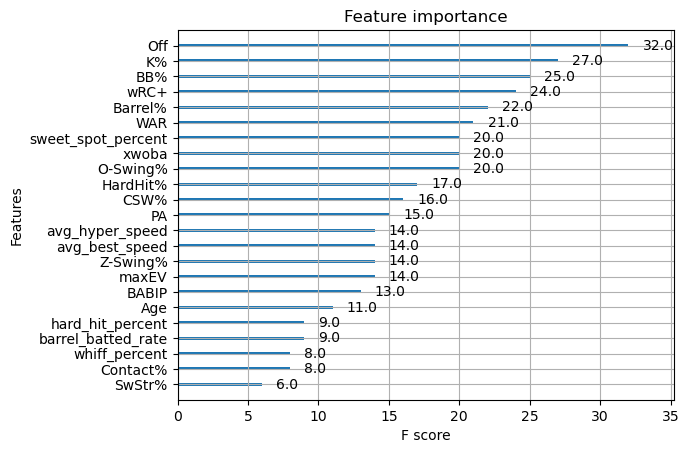

In [31]:
xgb.plot_importance(model)
plt.show()

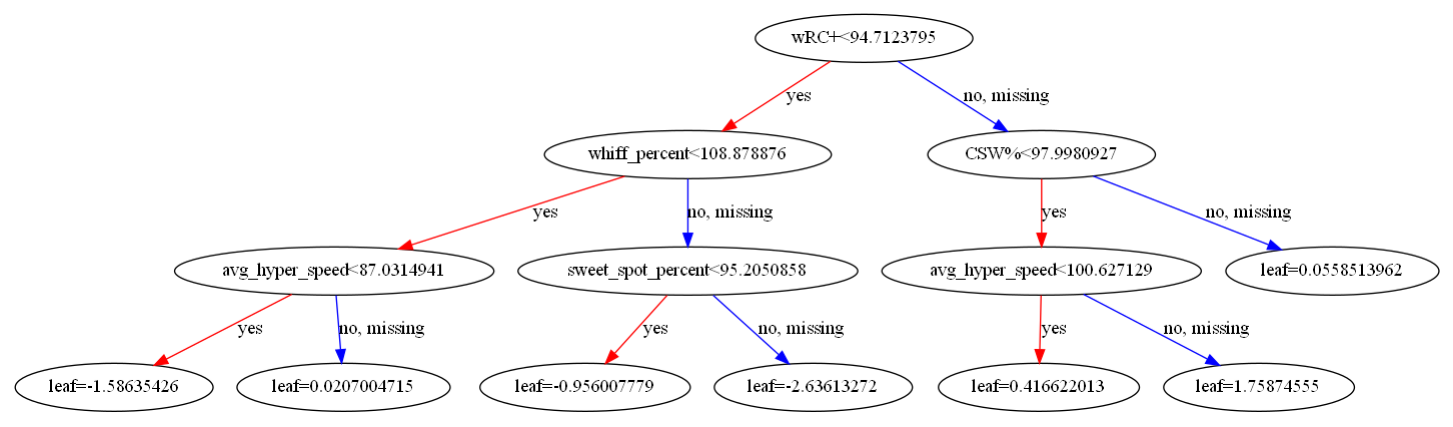

In [27]:
xgb.plot_tree(model)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

#### Metrics

In [34]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

r2 = r2_score(y_true=ytest, y_pred=ypreds)
mae = mean_absolute_error(y_true=ytest, y_pred=ypreds)
rmse = root_mean_squared_error(y_true=ytest, y_pred=ypreds)

print(f"R^2: {r2} \n mse: {mae} \n rmse: {rmse}")

R^2: 0.1874060713770742 
 mse: 23.906371211737714 
 rmse: 32.920628740408226


#### 2025 Predections

In [36]:
season = z_score_df[z_score_df['Season'] >= 2024].copy()
season = season.reset_index()
season.drop(columns=['index'], inplace=True)
season_pred = season.drop(columns=['Name', 'woba','player_id', 'pa', 'bb_percent', 'k_percent', 'woba', 'BsR', 'Def', 'Season', 'swing_percent', 'Z-Contact%', 'O-Contact%'])

In [37]:
preds_2025 = model.predict(season_pred)
preds_2025 = pd.DataFrame(preds_2025)
preds_2025['Name'] = season['Name']

In [38]:
preds_2025.to_csv('./models/wrc_models/2025_Predections/reg_23_preds.csv')